In [1]:
# Import necessary packages
import os
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil.parser import parse
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

os.chdir("/home/maina/Documents/Air Pollution Monitoring")

# import data_retrival and analysis functions
from data_analysis import *

2022-01-11 23:56:14.294716: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-11 23:56:14.294740: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Gets the data from firebase, process it and store it in a csv file
filepath = read_data()

# Read the dataset as a pandas dataframe
df = pd.read_csv(filepath)

# Display the first 10 rows
df.head(10)

,timestamp,mq7,mq135,temperature,humidity
0,1639922725,162.0,39.0,24.1,73.0
1,1639923325,135.0,38.0,23.9,75.0
2,1639923927,118.0,36.0,24.0,72.0
3,1639924555,109.0,39.0,24.4,73.0
4,1639925428,102.0,42.0,24.2,74.0
5,1639926056,100.0,42.0,24.2,76.0
6,1639926658,97.0,40.0,24.2,75.0
7,1639927411,96.0,37.0,24.0,77.0
8,1639928191,92.0,37.0,23.9,77.0
9,1639928791,92.0,37.0,23.9,77.0


In [3]:
# Converting the unix time stamp to datetime format
df["timestamp"] = pd.to_datetime(df['timestamp'], unit='s')
df["timestamp"] = df["timestamp"].dt.tz_localize('Africa/Nairobi')
df.head()

,timestamp,mq7,mq135,temperature,humidity
0,2021-12-19 14:05:25+03:00,162.0,39.0,24.1,73.0
1,2021-12-19 14:15:25+03:00,135.0,38.0,23.9,75.0
2,2021-12-19 14:25:27+03:00,118.0,36.0,24.0,72.0
3,2021-12-19 14:35:55+03:00,109.0,39.0,24.4,73.0
4,2021-12-19 14:50:28+03:00,102.0,42.0,24.2,74.0


In [4]:
# Check if there are any missing values in the dataset
df.isnull().sum()

timestamp      0
mq7            0
mq135          0
temperature    0
humidity       0
dtype: int64

In [5]:
# Statistical summary of the dataset columns
df.describe()

,mq7,mq135,temperature,humidity
count,2259.000000,2259.000000,2259.000000,2259.000000
mean,86.250996,41.467463,24.175255,62.943977
std,16.157806,8.528864,2.597867,10.145756
min,49.000000,27.000000,19.900000,22.000000
25%,78.000000,37.000000,22.450000,59.000000
50%,82.000000,40.000000,23.600000,66.400000
75%,90.000000,43.000000,25.050000,68.000000
max,199.000000,135.000000,35.700000,82.000000


array([<AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>,
       <AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>],
      dtype=object)

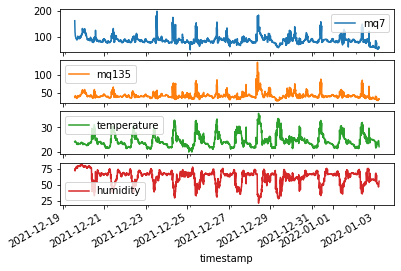

In [6]:
# plot the values against time
df.set_index("timestamp")[["mq7", "mq135", "temperature", "humidity"]].plot(subplots=True)

In [7]:
x = df[["mq7", "mq135", "temperature", "humidity"]].to_numpy()
y = df[["mq7", "mq135"]].to_numpy()

In [8]:
x[:10]

array([[162. ,  39. ,  24.1,  73. ],
       [135. ,  38. ,  23.9,  75. ],
       [118. ,  36. ,  24. ,  72. ],
       [109. ,  39. ,  24.4,  73. ],
       [102. ,  42. ,  24.2,  74. ],
       [100. ,  42. ,  24.2,  76. ],
       [ 97. ,  40. ,  24.2,  75. ],
       [ 96. ,  37. ,  24. ,  77. ],
       [ 92. ,  37. ,  23.9,  77. ],
       [ 92. ,  37. ,  23.9,  77. ]])

In [9]:
y[:10]

array([[162.,  39.],
       [135.,  38.],
       [118.,  36.],
       [109.,  39.],
       [102.,  42.],
       [100.,  42.],
       [ 97.,  40.],
       [ 96.,  37.],
       [ 92.,  37.],
       [ 92.,  37.]])

In [10]:
ts_generator = TimeseriesGenerator(x, y, length=6, sampling_rate=1, batch_size=1)
ts_generator[0]

(array([[[162. ,  39. ,  24.1,  73. ],
         [135. ,  38. ,  23.9,  75. ],
         [118. ,  36. ,  24. ,  72. ],
         [109. ,  39. ,  24.4,  73. ],
         [102. ,  42. ,  24.2,  74. ],
         [100. ,  42. ,  24.2,  76. ]]]),
 array([[97., 40.]]))

In [11]:
df

,timestamp,mq7,mq135,temperature,humidity
0,2021-12-19 14:05:25+03:00,162.0,39.0,24.1,73.0
1,2021-12-19 14:15:25+03:00,135.0,38.0,23.9,75.0
2,2021-12-19 14:25:27+03:00,118.0,36.0,24.0,72.0
3,2021-12-19 14:35:55+03:00,109.0,39.0,24.4,73.0
4,2021-12-19 14:50:28+03:00,102.0,42.0,24.2,74.0
...,...,...,...,...,...
2254,2022-01-03 05:02:50+03:00,55.0,32.0,24.6,47.0
2255,2022-01-03 05:07:57+03:00,60.0,33.0,24.2,48.0
2256,2022-01-03 05:23:17+03:00,62.0,33.0,23.8,51.0
2257,2022-01-03 05:38:36+03:00,58.0,31.0,22.7,56.0
